In [100]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.compose import ColumnTransformer 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.inspection import permutation_importance

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import xgboost as xgb
import shap

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


In [101]:
import captum

# Load TabNet

In [102]:
retrain = False

data = load_pickle_data_palettes()

results_pickle_folder = "../pickle/"

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features = data["df_select_features"]
df_select_features.columns = ["RNA", "CSF", "DNA", "MRIth"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

In [103]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

df_X_train = df_X.loc[idx_train]
df_X_test = df_X.loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [104]:
import io 

results_file = '../pickle/training_2_dict_results.pickle'
if retrain : 
    all_dict_results = []
    tabnet_model =  TabNetModelWrapper(n_a=8, n_d=8)#   XGBoostRegressor() #  TabNetModelWrapper(n_a=8, n_d=8)
else :  

    class CPU_Unpickler(pickle.Unpickler):
        def find_class(self, module, name):
            if module == 'torch.storage' and name == '_load_from_bytes':
                return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
            else:
                return super().find_class(module, name)
        
    if os.path.exists(results_file): 
        with open(results_file, "rb") as f:
            all_dict_results = CPU_Unpickler(f).load()
        
    tabnet_model = all_dict_results[9]["model"] # Corresponds to TabNet trained in notebook #3  

    model_instance = tabnet_model.model
    model_instance.device_name = "cpu"
    model_instance.network.to(torch.device("cpu"))

    tabnet_model.model = model_instance.network.to("cpu")

continuous_model  = imputer = KNNImputer(n_neighbors=5)
name_continuous_imputer  = "KNNImputer_5"
ordinal_model =  KNNImputer(n_neighbors=1)
name_ordinal_imputer = "KNNImputer"
name_model = "TabNetRegressor" # "XGBoostRegressor"#  "TabNetRegressor"

In [105]:
print(type(tabnet_model))           # Should be your wrapper class
print(type(tabnet_model.model))     # Should be <class 'pytorch_tabnet.tab_model.TabNetRegressor'>
print(hasattr(tabnet_model.model, 'device_name'))  # Should be T
tabnet_model.model.device_name = "cpu"

model_cpu = TabNetRegressor()
model_cpu.network = tabnet_model.model  # Assign your TabNet object
model_cpu.device_name = "cpu"
model_cpu.device = torch.device("cpu")

<class 'src.wrapper.TabNetModelWrapper'>
<class 'pytorch_tabnet.tab_network.TabNet'>
False


In [106]:
ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

# Separate imputers for ordinal and continuous data
print("Using separate imputers for ordinal and continuous data.")

df_X_train = df_X_train.copy()
df_X_test = df_X_test.copy()

for col in ordinal_features:
    df_X_train[col] = df_X_train[col].astype("category")
    df_X_test[col] = df_X_test[col].astype("category")

# Continuous Imputation Transformer (Example: SimpleImputer)
continuous_imputer = Pipeline([
    (name_continuous_imputer, continuous_model),
])

# Ordinal Imputation Transformer (Example: KNN Imputer)
ordinal_imputer = Pipeline([
    (name_ordinal_imputer, ordinal_model)
])

# Create a ColumnTransformer to apply the appropriate imputer to each type of variable
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_imputer, ordinal_features),
        ('continuous', continuous_imputer, continuous_features)
    ],
    remainder='passthrough'
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

    # Separate imputers for ordinal and continuous data

# Fit and transform, then convert back to DataFrame with original column names
start = time.time()
pipeline.fit(df_X_train)
end = time.time()

impute_model_time = end - start

X_train_imputed = pipeline.transform(df_X_train)
df_X_train_imputed = df_X_train.copy()
df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

# Transform the test set
if df_X_test.isna().any().any(): 
    X_test_imputed = pipeline.transform(df_X_test)
    df_X_test_imputed = df_X_test.copy()
    df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
else : 
    print("No NaN in test data -> Keep as it is. ")
    df_X_test_imputed = df_X_test

df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("category", errors='ignore')
df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("category", errors='ignore')

# Demographics adjustment for y
demographic_adjustment_y = DemographicAdjustmentTransformer()

y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

# Demographics adjustment for X
demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

# Standardize only continuous features
scaler = StandardScaler()

X_train_adjusted[continuous_features] = scaler.fit_transform(X_train_adjusted[continuous_features])
X_test_adjusted[continuous_features] = scaler.transform(X_test_adjusted[continuous_features])

if retrain: 
    # Perform prediction and save variables
    start = time.time()
    model_cpu.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start
    print("Training time: ", end - start)
else : 
    predict_model_time = None

y_pred_adjusted = model_cpu.predict(X_test_adjusted.values)

y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

# Metrics computed in original space
y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

params = {
    "ordinal_imputer": name_ordinal_imputer, 
    "continuous_imputer": name_continuous_imputer, 
    "model": name_model, "train_shape" : X_train_adjusted.shape, 
    "test_shape": X_test_adjusted.shape
}

def compute_all_metrics(y_test, y_pred): 
    # Metrics computed in adjusted space
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
    mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    r2 = r2_score(y_test,y_pred, multioutput="raw_values")
    explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

    try: 
        corr_p = correlation(y_pred, y_test)
    except: 
        print("Problem when computing correlation!")
        if type(y_test) != type(y_pred): 
            print("Type of inputs is different.")
            corr_p = None
        else : 
            corr_p = pearsonr(y_test, y_pred)

    return mse_score, mae_score, r2, explained_variance, corr_p

if df_X_test.shape[0] != 1: 

    # Metrics computed in adjusted space
    mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

    results_adj = {
        "mse_score": mse_score_adj, 
        "mae_score":mae_score_ajd, 
        "r2":r2_adj, 
        "explained_variance":explained_variance_adj, 
        "corr":corr_adj, 
    }

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

    results_org = {
        "mse_score": mse_score, 
        "mae_score": mae_score, 
        "r2": r2, 
        "explained_variance": explained_variance, 
        "corr": corr, 
    }
    
    print("Saving predictions in dict!")
    results_adj = {
        "y_pred": y_pred_adjusted.values, 
        "y_test": y_test_adjusted.values,
    }

    results_org = {
        "y_pred": y_pred.values, 
        "y_test": df_y_test.values,
    }


dict_results = {
    "params": params, 
    "imputation_time": impute_model_time,
    "fitting_time": predict_model_time, 
    "results_adj": results_adj, 
    "results_org": results_org
    }

Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 
Saving predictions in dict!


In [107]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

Domain: ADNI_MEM, Pearson correlation: 0.678, Pearson p-value: 0.011, MAE: 0.677
Domain: ADNI_EF, Pearson correlation: 0.722, Pearson p-value: 0.005, MAE: 0.633
Domain: ADNI_VS, Pearson correlation: 0.553, Pearson p-value: 0.050, MAE: 0.473
Domain: ADNI_LAN, Pearson correlation: 0.556, Pearson p-value: 0.049, MAE: 0.749


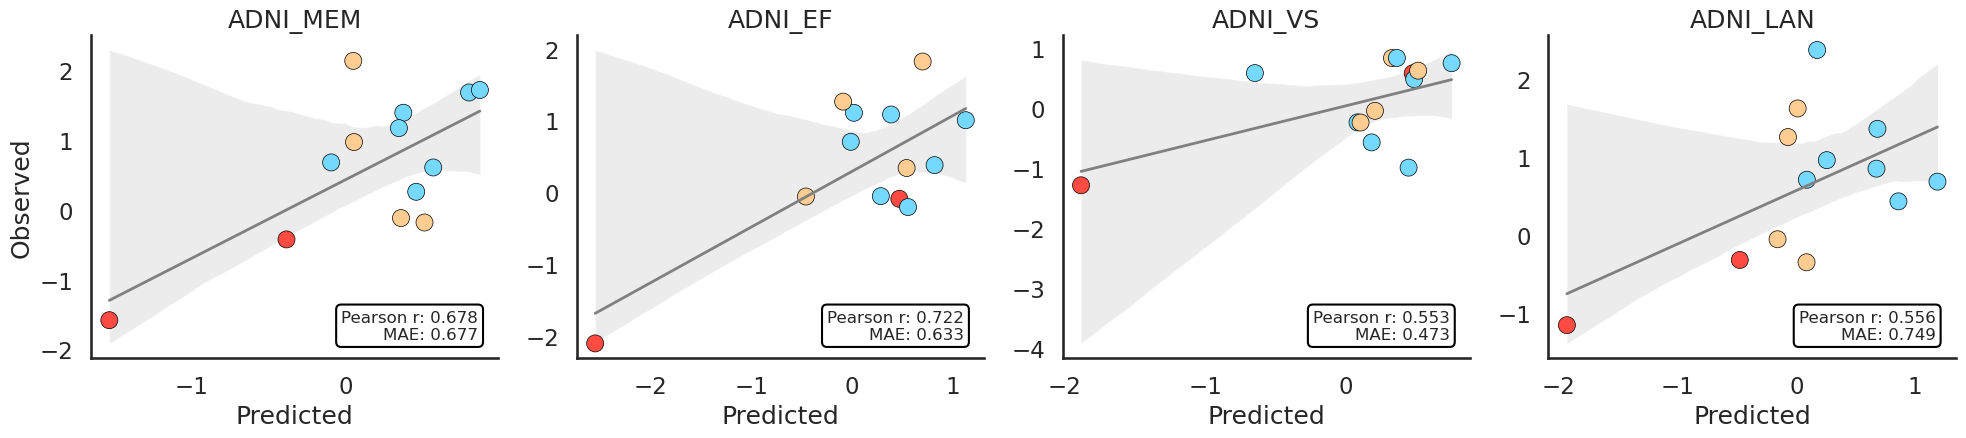

In [108]:
# Set style with no grid and larger context
sns.set_style("white")
sns.set_context("talk")  # Larger font sizes

# Create the lmplot without scatter points and no title
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # No scatter points from lmplot
    line_kws={"color": "grey", "lw": 2},
    legend=False  # No legend from lmplot
)

# Overlay scatter points with large size and annotations
cognitive_domains_order = g.col_names

for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]

    # Scatter points
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=150,  # Bigger scatter points
        edgecolor='black',  # Optional for clarity
        linewidth=0.5,
        legend=False  # No legend from scatterplot
    )
    
    # Legend styling
    ax.legend(loc="upper left", title="Diagnosis", fontsize=12, title_fontsize=13)
    
    # Metrics
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])

    print(f"Domain: {cognitive_domain}, Pearson correlation: {pearsonr(group_data['y_pred'], group_data['y_test'])[0]:.3f}, Pearson p-value: {pearsonr(group_data['y_pred'], group_data['y_test'])[1]:.3f}, MAE: {mae:.3f}")
    
    # Annotation
    ax.text(
        0.95, 0.05,
        f"Pearson r: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )
    ax.legend_.remove()  # Remove legend from each subplot

# Axis labels
g.set_axis_labels("Predicted", "Observed")
g.set_titles("{col_name}")  # Removes subtitle formatting

# Remove the main title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("")  # Set to empty to remove title

# Final layout cleanup
sns.despine()
plt.tight_layout()
plt.show()

# Captum

In [109]:
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, LayerConductance
from captum.attr import visualization as viz


In [115]:
X_tensor = torch.tensor(X_train_adjusted.values, dtype=torch.float32)
y_tensor = torch.tensor(df_y_train.values, dtype=torch.float32)

In [111]:
import torch
from captum.attr import (
    FeatureAblation, FeaturePermutation, Occlusion, ShapleyValueSampling
)

def compute_perturbation_attrs(
    model_predict, X: torch.Tensor, output_idx: int = 0, shapley_samples: int = 100
) -> dict:
    """
    Compute perturbation-based attributions for a selected output in a multi-output model.

    Args:
        model_predict: callable numpy-output predictor, shape (N, D)
        X: torch.Tensor of shape (N, F)
        output_idx: which output dimension to explain
        shapley_samples: number of samples for ShapleyValueSampling

    Returns:
        dict of attribution tensors, e.g., {'ablation': Tensor(N,F), ...}
    """
    def forward_i(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    attrs = {}
    attrs['ablation'] = FeatureAblation(forward_i).attribute(X, baselines=0)
    attrs['permutation'] = FeaturePermutation(forward_i).attribute(X)
    attrs['occlusion'] = Occlusion(forward_i).attribute(X, baselines=0, sliding_window_shapes=(1,))
    attrs['shapley'] = ShapleyValueSampling(forward_i).attribute(X, baselines=0, n_samples=shapley_samples)

    return attrs


In [112]:
def compute_perturbation_attrs(
    model_predict, X: torch.Tensor, output_idx: int = 0, shapley_samples: int = 100
) -> dict:
    """
    Compute perturbation-based attributions for a selected output in a multi-output model.

    Args:
        model_predict: callable numpy-output predictor, shape (N, D)
        X: torch.Tensor of shape (N, F)
        output_idx: which output dimension to explain
        shapley_samples: number of samples for ShapleyValueSampling

    Returns:
        dict of attribution tensors, e.g., {'ablation': Tensor(N,F), ...}
    """
    def forward_predict(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    explainers = {
        'ablation': FeatureAblation(forward_predict).attribute(X, baselines=0),
        'permutation': FeaturePermutation(forward_predict).attribute(X),
        'occlusion': Occlusion(forward_predict).attribute(X, baselines=0, sliding_window_shapes=(1,)),
        'shapley': ShapleyValueSampling(forward_predict).attribute(X, baselines=0, n_samples=shapley_samples)
    }

    return explainers, forward_predict

In [116]:
model_predict = model_cpu.predict  # your numpy-based predictor

explainers_0, forward_0 = compute_perturbation_attrs(
    model_predict, X_tensor, output_idx=0, shapley_samples=50
)

In [117]:
explainers_1, forward_1 = compute_perturbation_attrs(
    model_predict, X_tensor, output_idx=1, shapley_samples=50
)

In [118]:
explainers_2, forward_2 = compute_perturbation_attrs(
    model_predict, X_tensor, output_idx=2, shapley_samples=50
)

In [119]:
explainers_3, forward_3 = compute_perturbation_attrs(
    model_predict, X_tensor, output_idx=2, shapley_samples=50
)

## Plot attribution methods

In [120]:
def format_attrs_for_plot(explainers: dict, feature_names: list) -> pd.DataFrame:
    """
    Convert explainers dict to a DataFrame with columns:
    'method', 'feature', 'avg_abs_attr', 'std_abs_attr'.
    
    explainers: dict e.g. {'ablation': Tensor(N,F), ...}
    feature_names: list of length F
    """
    rows = []
    for method, tensor in explainers.items():
        arr = tensor.detach().cpu().numpy()  # shape (N, F)
        avg_abs = np.mean(np.abs(arr), axis=0)  # vector length F
        std_abs = np.std(np.abs(arr), axis=0)  # vector length F
        for feat_name, avg, std in zip(feature_names, avg_abs, std_abs):
            rows.append({
                'method': method,
                'feature': feat_name,
                'avg_abs_attr': avg,
                'std_abs_attr': std
            })
    return pd.DataFrame(rows)


In [128]:
n_features = 20
plt_std = False
all_explainers = [explainers_0, explainers_1, explainers_2, explainers_3]

for target, explainer in zip(df_y.columns, all_explainers): 
    
    df_attr = format_attrs_for_plot(explainer, X_test_adjusted.columns.tolist())
    top_ft_to_plot = df_attr.groupby("feature")['avg_abs_attr'].mean().sort_values(ascending=False).head(n_features).index.tolist()
    plt_df = df_attr[df_attr['feature'].isin(top_ft_to_plot)]

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=plt_df,
        x='feature',
        y='avg_abs_attr',
        hue='method',
        ci=None,  # Disable Seaborn's internal CI calculation
        capsize=0.1,
        errwidth=1,
        order=top_ft_to_plot
    )
    
    # Add error bars manually
    features = plt_df['feature'].unique()
    methods = plt_df['method'].unique()
    n_methods = len(methods)
    total_width = 0.8  # seaborn default total width for group
    single_width = total_width / n_methods

    if plt_std == True: 

        for i, feature in enumerate(features):
            for j, method in enumerate(methods):
                x = i - total_width/2 + j * single_width + single_width/2
                row = plt_df[(plt_df['feature'] == feature) & (plt_df['method'] == method)]
                if row.empty:
                    continue
                y = row['avg_abs_attr'].values[0]
                yerr = row['std_abs_attr'].values[0]
                plt.errorbar(x, y, yerr=yerr, fmt='none', ecolor='black', capsize=3, elinewidth=1)
        
    plt.xticks(rotation=90)
    plt.title(f'Top {n_features} Feature Importances for Target: {target}')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f"../figures/captum/tabnet_perturbation_attr_comparison_{target}.png", bbox_inches="tight")
    plt.close()


## Plot perbutation importances 

In [129]:
# Parameters
n_features = 20
all_explainers = [explainers_0, explainers_1, explainers_2, explainers_3]

# Mappings & style
readable_names = {
    "ADNI_MEM": "Memory",
    "ADNI_EF": "Executive Function",
    "ADNI_VS": "Visuospatial",
    "ADNI_LAN": "Language"
}
sns.set_style("white")
sns.set_context("talk")

# Convert df_select_features to dict of lists {category: [features]}
category_dict = df_select_features.to_dict(orient="list")

# Reverse mapping feature -> category for quick lookup
feature_to_category = {}

for cat, features in category_dict.items():
    for f in features:
        feature_to_category[f] = cat

# Define your palette (make sure it matches categories)
category_palette = {'RNA': full_palette["yellow"],
 'MRIth': full_palette["cyan"],
 'CSF': full_palette["blue"],
 'DNA': full_palette["orange"],
 'ADNI_cog': full_palette["green"]
 }
sns.color_palette(category_palette.values())

def clean_ytick_label(label):
    # Your cleaning logic here, e.g.:
    label = label.replace("_", " ")
    label = label.replace("LH", "Left ")
    label = label.replace("RH", "Right ")
    return label

n_features = 20
plt_std = False
all_explainers = [explainers_0, explainers_1, explainers_2, explainers_3]

for target, explainer in zip(df_y.columns, all_explainers): 
    df_attr = format_attrs_for_plot(explainer, X_test_adjusted.columns.tolist())
    
    methods = df_attr['method'].unique()
    
    for method in methods:
        df_method = df_attr[df_attr['method'] == method]
        top_method_feats = df_method.sort_values('avg_abs_attr', ascending=False).head(n_features)
        
        # Map modality category for colors (assuming df_select_features is defined)
        top_method_feats['Category'] = top_method_feats['feature'].map(
            lambda feature: next(
                (key for key, columns in df_select_features.to_dict(orient="list").items() if feature in columns), 
                'Unknown')
        )
        
        plt.figure(figsize=(8, 6))
        sns.set_style("white")
        sns.set_context("talk")
        
        ax = sns.barplot(
            data=top_method_feats,
            y='feature',  # horizontal bars
            x='avg_abs_attr',
            hue='Category',
            palette=category_palette,
            orient='h'
        )
        
        # Clean y-tick labels if needed
        ytick_labels = [tick.get_text() for tick in ax.get_yticklabels()]
        new_labels = [clean_ytick_label(label) for label in ytick_labels]
        ax.set_yticklabels(new_labels)
        
        readable_title = readable_names.get(target, target)
        ax.set_title(f'{readable_title} - {method}', fontsize=18)
        ax.set_xlabel('Average Absolute Attribution', fontsize=16)
        ax.set_ylabel('Feature', fontsize=16)
        
        ax.legend(loc='best', fontsize=12)
        sns.despine()
        plt.tight_layout()
        
        plt.savefig(f"../figures/captum/{target}_{method}_top_features.png", bbox_inches='tight')
        plt.close()


## Save to csv for brain maps

In [130]:
def extract_features_to_matrix(permutation_results, select_key, select_features):
    """
    Extract specific features from DataFrames in a dictionary and stitch them into a matrix.
    
    Args:
    - permutation_results (dict): Dictionary with keys (e.g., ['ADNI_MEM', 'ADNI_EF', ...])
                                  and values as DataFrames with 'Feature' and 'Importance' columns.
    - select_key (str): The key in the `select` dictionary to extract features from.
    - select_features (pd.Index or list): List or Index of features to extract.

    Returns:
    - pd.DataFrame: A matrix (DataFrame) where rows are features and columns are the keys from `permutation_results`.
    """
    # Initialize an empty dictionary to store extracted features
    extracted_data = {}
    
    for key, df in permutation_results.items():
        # Filter the DataFrame to include only the selected features in the specified order
        filtered_df = df[df['Feature'].isin(select_features)]
        # Reindex to ensure the features are in the same order as select_features
        reindexed_df = filtered_df.set_index('Feature').reindex(select_features)
        # Extract the Importance values
        extracted_data[key] = reindexed_df['Importance'].values
    
    # Combine the extracted Importance values into a single DataFrame
    combined_matrix = pd.DataFrame(extracted_data, index=select_features)
    
    return combined_matrix

In [125]:
methods = explainers_0.keys()

In [131]:
all_explainers = [explainers_0, explainers_1, explainers_2, explainers_3]

for method in methods:
    dict_to_csv = {}
    for target, explainer in zip(df_y.columns, all_explainers): 
        df_attr = format_attrs_for_plot(explainer, X_test_adjusted.columns.tolist())

        df_method = df_attr[df_attr['method'] == method]
        dict_to_csv[target] = df_method[["feature", "avg_abs_attr"]].rename(columns={"feature": "Feature", "avg_abs_attr":"Importance"})
    matrix_to_brain = extract_features_to_matrix(dict_to_csv, 'MRIth', select_MRIthickness)
    matrix_to_brain.to_csv(f'../figures/captum/brain_maps/tabnet_{method}_to_brain.csv', index=False, header=False)

# Compute metrics

In [142]:
from captum.attr import FeatureAblation, FeaturePermutation, Occlusion, ShapleyValueSampling
from captum.metrics import infidelity, sensitivity_max
import torch

def get_explainer(key, forward_func):
    if key == 'ablation':
        return FeatureAblation(forward_func)
    elif key == 'permutation':
        return FeaturePermutation(forward_func)
    elif key == 'occlusion':
        return Occlusion(forward_func)
    elif key == 'shapley':
        return ShapleyValueSampling(forward_func)
    else:
        raise ValueError(f"Unknown explainer key: {key}")

def compute_metrics(forward_func, X, explainer_keys, perturbation_samples=10, sens_radius=0.02):
    results = {}

    for key in explainer_keys:
        explainer = get_explainer(key, forward_func)

        # Define explanation function
        def explanation_fn(inputs):
            if key in ['ablation', 'occlusion', 'shapley']:
                baseline = torch.zeros_like(inputs)
                return explainer.attribute(inputs, baselines=baseline)
            else:
                return explainer.attribute(inputs)

        # Define perturbation function for infidelity
        def perturb_func(inputs, baselines):
            noise = torch.randn_like(inputs) * 0.01
            return None, inputs + noise

        # Compute infidelity
        inf = infidelity(
            forward_func,
            perturb_func,
            X,
            explanation_fn,
            normalize=True
        )

        # Compute sensitivity
        sens = sensitivity_max(
            explanation_fn,
            X,
            perturb_radius=sens_radius,
            n_perturb_samples=perturbation_samples,
            norm_ord='fro'
        )

        results[key] = {
            'infidelity': inf.item(),
            'sensitivity': sens.item()
        }

    return results


In [144]:
# Set sample size and random seed for reproducibility
sample_size = 100  # or any smaller number you prefer
torch.manual_seed(42)  # optional, for reproducibility

# Generate random indices and subset
indices = torch.randperm(X_tensor.size(0))[:sample_size]
X_sampled = X_tensor[indices]


In [155]:
import torch
from captum.metrics import infidelity

def compute_infidelity(
    forward_func,        # your model's forward function
    X: torch.Tensor,     # input tensor, shape (N, F)
    attributions: torch.Tensor,  # precomputed attribution tensor, same shape as X
    n_perturb_samples: int = 10,
    noise_scale: float = 0.01,
    normalize: bool = True
) -> torch.Tensor:
    """
    Returns a tensor of infidelity scores, one per example (shape (N, 1)).
    """
    def perturb_fn(inputs, baselines=None):
        noise = torch.randn_like(inputs) * noise_scale
        perturbed = inputs + noise
        return noise, perturbed

    inf_vals = infidelity(
        forward_func,
        perturb_fn,
        inputs=X,
        attributions=attributions,
        baselines=None,
        n_perturb_samples=n_perturb_samples,
        normalize=normalize
    )
    return inf_vals


In [185]:
scores = compute_infidelity(
    forward_0 , torch.tensor(X_tensor), explainers_0["ablation"],
    n_perturb_samples=50,
    noise_scale=0.1,
    normalize=True
)
print("Infidelity per sample:", scores)

Infidelity per sample: tensor([0.0041, 0.0183, 0.0130,  ..., 0.0006, 0.0002, 0.0210])


In [186]:
all_explainers = [explainers_0, explainers_1, explainers_2, explainers_3]
all_funcs = [forward_0, forward_1, forward_2, forward_3]

In [187]:
infidelity_scores = {}

for target, explainer, forward_func in zip(df_y.columns, all_explainers, all_funcs): 
    df_attr = format_attrs_for_plot(explainer, X_test_adjusted.columns.tolist())
    
    methods = df_attr['method'].unique()

    infidelity_scores[target] = {}
    
    for method in methods:
        inf = compute_infidelity(
            forward_func , X_tensor, explainer[method],
            n_perturb_samples=50,
            noise_scale=0.02,
            normalize=True
        )

        # Store the computed scores
        infidelity_scores[target][method] = inf.squeeze().tolist()

        print("Infidelity per sample:", inf)

Infidelity per sample: tensor([2.0110e-04, 1.2285e-04, 5.7727e-04,  ..., 1.3458e-05, 6.5748e-06,
        7.2944e-04])
Infidelity per sample: tensor([2.3292e-04, 1.0372e-04, 7.4318e-04,  ..., 1.0549e-05, 7.2621e-06,
        1.0044e-03])
Infidelity per sample: tensor([1.6269e-04, 1.1690e-04, 8.2438e-04,  ..., 1.5710e-05, 8.0000e-06,
        1.1770e-03])
Infidelity per sample: tensor([2.9909e-04, 1.1606e-04, 6.9441e-04,  ..., 2.0776e-05, 1.0984e-05,
        4.6144e-04])
Infidelity per sample: tensor([7.2163e-05, 6.2925e-05, 2.0563e-04,  ..., 4.2514e-05, 2.8559e-05,
        4.4279e-04])
Infidelity per sample: tensor([4.5578e-05, 7.7679e-05, 1.1743e-04,  ..., 2.9114e-05, 3.0082e-05,
        3.6311e-04])
Infidelity per sample: tensor([6.5911e-05, 6.4179e-05, 2.7010e-04,  ..., 3.9086e-05, 2.3615e-05,
        3.8770e-04])
Infidelity per sample: tensor([1.0845e-04, 4.3970e-05, 2.5768e-04,  ..., 4.2813e-05, 2.9500e-05,
        5.7982e-04])
Infidelity per sample: tensor([4.8852e-05, 4.7117e-05, 5

In [188]:

# Prepare data for plotting
plot_data = []

for target, methods in infidelity_scores.items():
    for method, scores in methods.items():
        for score in scores:
            plot_data.append({
                'Target': target,
                'Method': method,
                'Infidelity': score
            })

df_plot = pd.DataFrame(plot_data)

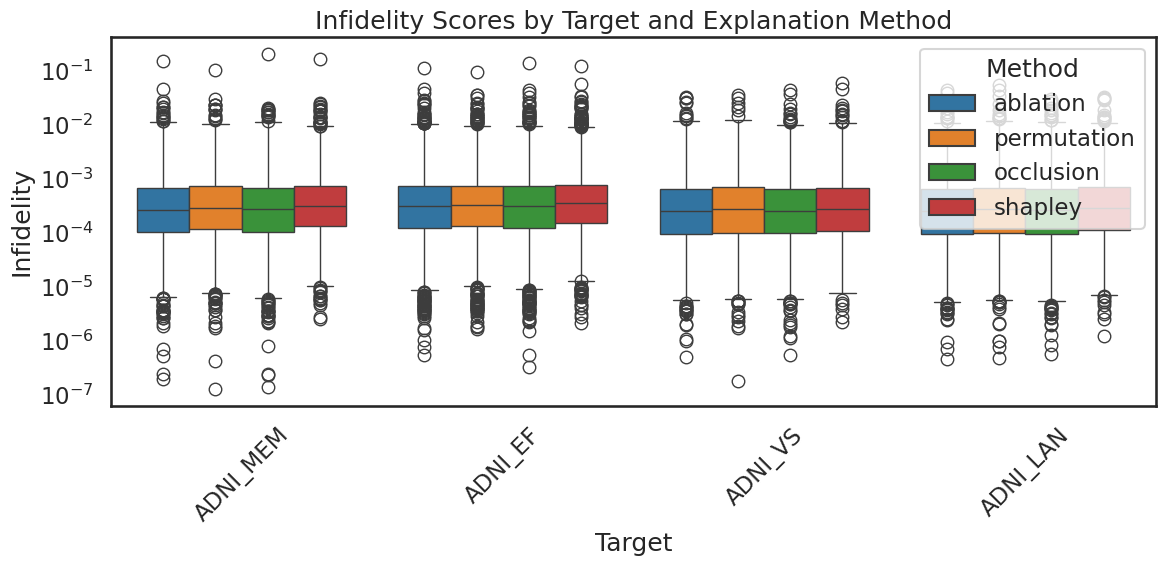

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Target', y='Infidelity', hue='Method', data=df_plot, log_scale=True)
plt.title('Infidelity Scores by Target and Explanation Method')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [190]:
df_plot.groupby(["Target", "Method"]).mean().sort_values("Infidelity", ascending=True)

Infidelity
Target   Method                 
ADNI_LAN occlusion      0.000662
         ablation       0.000671
ADNI_VS  occlusion      0.000676
         ablation       0.000679
         permutation    0.000693
ADNI_LAN shapley        0.000704
         permutation    0.000715
ADNI_VS  shapley        0.000726
ADNI_MEM occlusion      0.000743
         permutation    0.000750
         ablation       0.000758
         shapley        0.000788
ADNI_EF  ablation       0.000854
         occlusion      0.000866
         permutation    0.000869
         shapley        0.000938

## Debug

In [ ]:
import torch
from captum.attr import (
    FeatureAblation, FeaturePermutation, Occlusion, ShapleyValueSampling
)
from captum.metrics import infidelity, sensitivity_max

def compute_perturbation_attrs_with_metrics(
    model_predict, X: torch.Tensor, output_idx: int = 0, shapley_samples: int = 100, perturbation_samples: int = 50
) -> dict:
    def forward_i(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    baselines = torch.zeros_like(X)

    results = {}
    explainers = {
        'ablation': FeatureAblation(forward_i).attribute(X, baselines=0),
        'permutation': FeaturePermutation(forward_i).attribute(X),
        'occlusion': Occlusion(forward_i).attribute(X, baselines=0, sliding_window_shapes=(1,)),
        'shapley': ShapleyValueSampling(forward_i).attribute(X, baselines=0, n_samples=shapley_samples)
    }

    for name, attr in explainers.items():
        # Compute metrics
        inf = infidelity(
            forward_i, 
            lambda inp: (None, inp + torch.randn_like(inp) * 0.01),
            X, attr, baselines=baselines, n_perturb_samples=perturbation_samples, normalize=True
        )
        sens = sensitivity_max(
            forward_i,
            X, attr,
            stdevs=0.01,
            n_perturb_samples=perturbation_samples,
            abs=False
        )
        results[name] = {'attr': attr, 'infidelity': inf.item(), 'sensitivity': sens.item()}

    return results


In [ ]:
def compute_metrics_from_attr(model_predict, X: torch.Tensor, output_idx: int = 0, explainers: dict ={} , perturbation_samples: int = 50): 

    def forward_i(x):
        preds = model_predict(x.numpy())[:, output_idx]
        return torch.tensor(preds, dtype=torch.float32)

    baselines = torch.zeros_like(X)

    results = {}
    
    for name, attr in explainers.items():
        # Compute metrics
        inf = infidelity(
            forward_i, 
            lambda inp: (None, inp + torch.randn_like(inp) * 0.01),
            X, attr, baselines=baselines, n_perturb_samples=perturbation_samples, normalize=True
        )
        sens = sensitivity_max(
            forward_i,
            X, attr,
            stdevs=0.01,
            n_perturb_samples=perturbation_samples,
            abs=False
        )
        results[name] = {'attr': attr, 'infidelity': inf.item(), 'sensitivity': sens.item()}

    return results